In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils.model import CNN

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])


#    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize dataset


In [3]:
train_path = "Animal10/train_dataset"
val_path = "Animal10/val_dataset"

In [4]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
cls_names = train_dataset.classes
n_cls = len(cls_names)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = CNN(n_cls).to(device)

In [8]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))  # Input image size is mentioned on transform


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Flatten-10                [-1, 65536]               0
           Linear-11                  [-1, 256]      16,777,472
             ReLU-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 16,803,626
Trainable para

In [9]:
# from torchinfo import summary
# summary(model, input_size=(2, 3, 256, 256))  # Batch size of 2, with 3-channel images of size 256 * 256


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

def train_model(model, train_loader, optimizer, criterion, device, epochs, patience = 3):
    model.train()

    best_val_loss = float('inf')  # Set to a large number initially
    patience_counter = 0  # Counter to track how long validation loss has not improved

    for epoch in range(epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                #Forward pass
                outputs = model(images)
                _, predicted = outputs.max(1)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                loss.backward()
                optimizer.step()

                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update progress bar
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        record_loss = running_loss/len(train_loader)
        record_accuracy = 100*correct/total
        train_losses.append(record_loss)
        train_accuracy.append(record_accuracy)

        val_loss = validate_model(model, val_loader, criterion, device)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter if validation loss improves
            best_model_state = model.state_dict()  # Save the best model
            best_epoch = epoch + 1  # Track the epoch number (1-based index)
            # Save the model's state dictionary
            torch.save(model.state_dict(), 'model_weights.pth')
            print(f"Best model saved at epoch {best_epoch} with validation loss {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve for {patience_counter} epoch(s).")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_state)  # Load the best model state before overfitting occurred
            print(f"Model restored from epoch {best_epoch} with the best validation loss {best_val_loss:.4f}")
            break


In [11]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                #Forward pass
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update progress bar
                pbar.set_postfix(val_loss=val_running_loss / (pbar.n + 1))
                pbar.update(1)


    record_loss = val_running_loss/len(val_loader)
    record_accuracy = 100*correct/total
    val_losses.append(record_loss)
    val_accuracy.append(record_accuracy)
    print(f"Validation Accuracy: {record_accuracy:.2f}%")

    return record_loss


In [12]:
train_model(model, train_loader, optimizer, criterion, device, epochs=10)

Validation: 100%|██████████| 327/327 [00:27<00:00, 12.11batch/s, val_loss=1.48]


Validation Accuracy: 49.33%
Best model saved at epoch 1 with validation loss 1.4822


Validation: 100%|██████████| 327/327 [00:25<00:00, 12.84batch/s, val_loss=1.28]


Validation Accuracy: 57.05%
Best model saved at epoch 2 with validation loss 1.2783


Validation: 100%|██████████| 327/327 [00:24<00:00, 13.43batch/s, val_loss=1.15]


Validation Accuracy: 61.87%
Best model saved at epoch 3 with validation loss 1.1467


Validation: 100%|██████████| 327/327 [00:25<00:00, 12.71batch/s, val_loss=1.31]


Validation Accuracy: 60.47%
Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 327/327 [00:24<00:00, 13.55batch/s, val_loss=1.57]


Validation Accuracy: 61.12%
Validation loss did not improve for 2 epoch(s).


Validation: 100%|██████████| 327/327 [00:23<00:00, 14.12batch/s, val_loss=2.16]

Validation Accuracy: 59.84%
Validation loss did not improve for 3 epoch(s).
Early stopping triggered after 6 epochs.
Model restored from epoch 3 with the best validation loss 1.1467


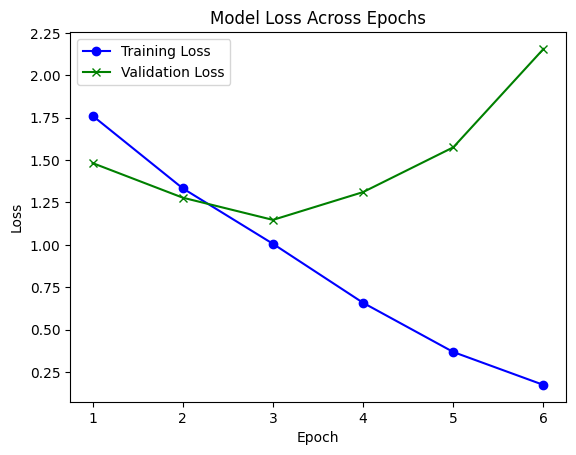

In [13]:
# Function to plot two lists of loss values for each epoch
def plot_loss_curves(train_losses, val_losses):
    # Round the values to 2 decimal places
    train_losses = [round(num, 3) for num in train_losses]
    val_losses =  [round(num, 3) for num in val_losses]


    # Epochs (1 to 10)
    epochs = range(1, len(val_losses)+1)

    # Plotting the losses of both models
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='green', marker='x')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Across Epochs')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
plot_loss_curves(train_losses, val_losses)


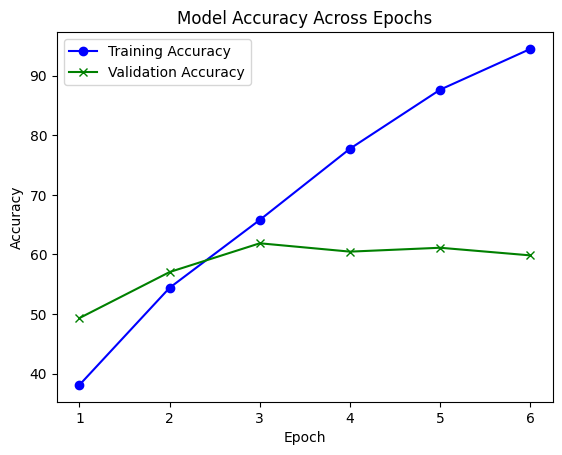

In [14]:
# Function to plot two lists of loss values for each epoch
def plot_accuracy_curves(train_accuracy, val_accuracy):
    # Round the values to 2 decimal places
    train_accuracy = [round(num, 2) for num in train_accuracy]
    val_accuracy =  [round(num, 2) for num in val_accuracy]


    # Epochs (1 to 10)
    epochs = range(1, len(val_accuracy)+1)

    # Plotting the losses of both models
    plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', marker='x')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Epochs')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
plot_accuracy_curves(train_accuracy, val_accuracy)


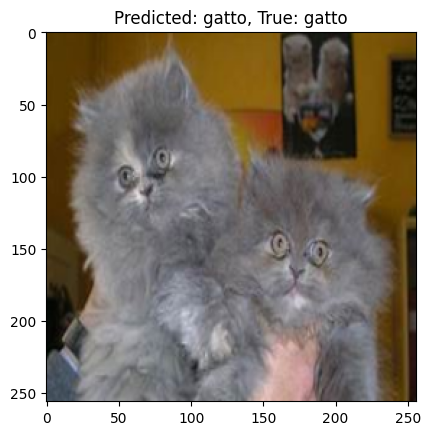

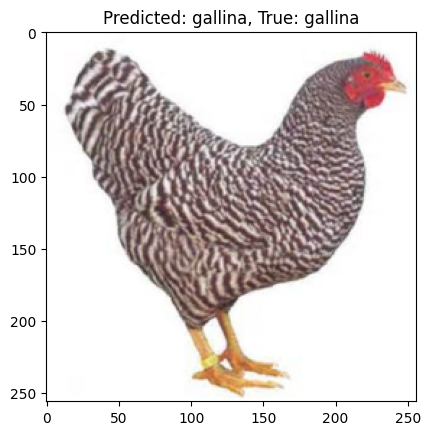

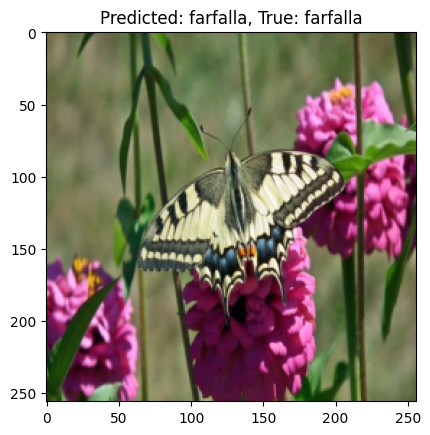

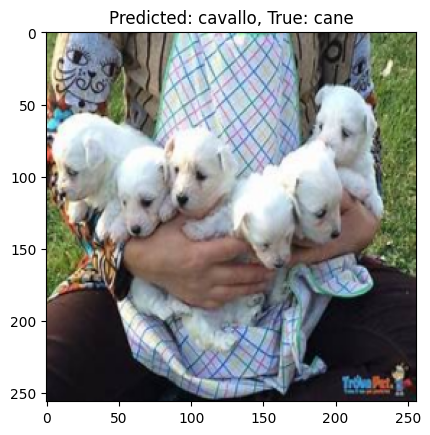

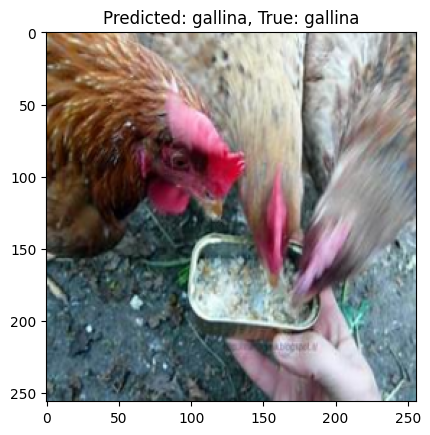

In [15]:
import matplotlib.pyplot as plt
# Function to visualize some predictions
def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs= model(images)
            _, predicted = outputs.max(1)

            for j in range(images.size(0)):
                images_so_far += 1
                plt.figure()
                image = images[j].cpu().numpy().transpose((1, 2, 0))
                plt.imshow(image)
                plt.title(f'Predicted: {cls_names[predicted[j].item()]}, True: {cls_names[labels[j].item()]}')
                plt.show()

                if images_so_far == num_images:
                    return

# Visualizing some predictions
visualize_predictions(model, val_loader, device)
